# Separation of means
> Compare the distributions for classification datasets, in terms of distances

In [2]:
import anndata

mlrepo = anndata.read_h5ad("../data/mlrepo6.h5ad")

Found 2 classes: ['Oral', 'Gastrointestinal_tract']
Categories (2, object): ['Gastrointestinal_tract', 'Oral']


['dnabert-s: Oral-Oral',
 'dnabert-s: Oral-Gastrointestinal_tract',
 'dnabert-s: Gastrointestinal_tract-Gastrointestinal_tract']

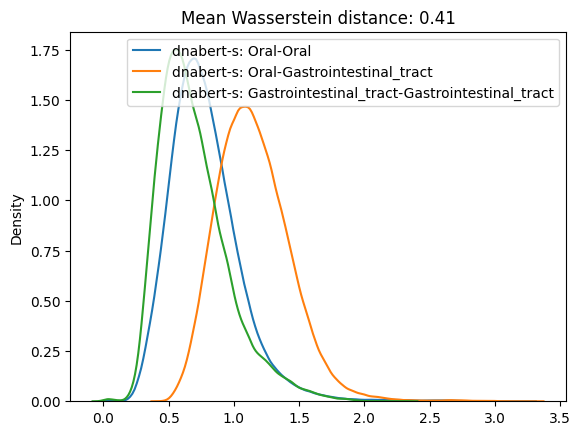

In [55]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

DATASET = "hmp_gastro-oral"
EMBEDDING = "dnabert-s"


def plot_distances(embedding, dataset, ax=None):
    if ax is None:
        _, ax = plt.subplots()

    # Get the filtered data
    mlrepo_filtered = mlrepo[~mlrepo.obs[dataset].isna()]

    # Get classes
    classes = mlrepo_filtered.obs[dataset].unique()
    print(f"Found {len(classes)} classes: {classes}")

    # Get pairwise distances - include intraclass
    all_dists = []
    all_labels = []

    for i, class_i in enumerate(classes):
        # Get indices for class_i instead of boolean mask
        indices1 = np.where(mlrepo_filtered.obs[dataset] == class_i)[0]
        for j in range(i, len(classes)):
            class_j = classes[j]
            # Get indices for class_j instead of boolean mask
            indices2 = np.where(mlrepo_filtered.obs[dataset] == class_j)[0]

            # Extract the submatrix using integer indices
            submatrix = mlrepo_filtered.obsp[embedding][indices1][:, indices2]

            # For intraclass comparisons, remove the diagonal elements (self-distances)
            if i == j:
                # If already dense, just exclude diagonal
                mask = np.ones(submatrix.shape, dtype=bool)
                np.fill_diagonal(mask, False)
                dists = submatrix[mask]
            else:
                # For interclass, use all distances
                dists = submatrix.flatten()

            all_dists.append(dists)
            all_labels.append(f"{embedding}: {class_i}-{class_j}")

    # Plot KDE of distances
    for dists, label in zip(all_dists, all_labels):
        ax = sns.kdeplot(dists, label=label, ax=ax, common_norm=False, common_grid=True)

    # Compute average Wasserstein distances - just the interclass ones - these indices are stable for binary classes
    all_wasserstein_dists = [
        wasserstein_distance(all_dists[0], all_dists[1]),
        wasserstein_distance(all_dists[2], all_dists[1]),
    ]

    ax.set_title(f"Mean Wasserstein distance: {np.mean(all_wasserstein_dists):.2f}")

    return ax, all_wasserstein_dists, all_labels


ax, wd, labels = plot_distances(EMBEDDING, DATASET)
ax.legend()
labels

  0%|          | 0/28 [00:00<?, ?it/s]

Found 2 classes: ['Oral', 'Gastrointestinal_tract']
Categories (2, object): ['Gastrointestinal_tract', 'Oral']
Found 2 classes: ['Oral', 'Gastrointestinal_tract']
Categories (2, object): ['Gastrointestinal_tract', 'Oral']
Found 2 classes: ['Oral', 'Gastrointestinal_tract']
Categories (2, object): ['Gastrointestinal_tract', 'Oral']
Found 2 classes: ['Oral', 'Gastrointestinal_tract']
Categories (2, object): ['Gastrointestinal_tract', 'Oral']
Found 2 classes: ['Oral', 'Gastrointestinal_tract']
Categories (2, object): ['Gastrointestinal_tract', 'Oral']
Found 2 classes: ['Oral', 'Gastrointestinal_tract']
Categories (2, object): ['Gastrointestinal_tract', 'Oral']
Found 2 classes: ['Oral', 'Gastrointestinal_tract']
Categories (2, object): ['Gastrointestinal_tract', 'Oral']
Found 2 classes: ['Oral', 'Gastrointestinal_tract']
Categories (2, object): ['Gastrointestinal_tract', 'Oral']
Found 2 classes: ['Oral', 'Gastrointestinal_tract']
Categories (2, object): ['Gastrointestinal_tract', 'Oral']
F

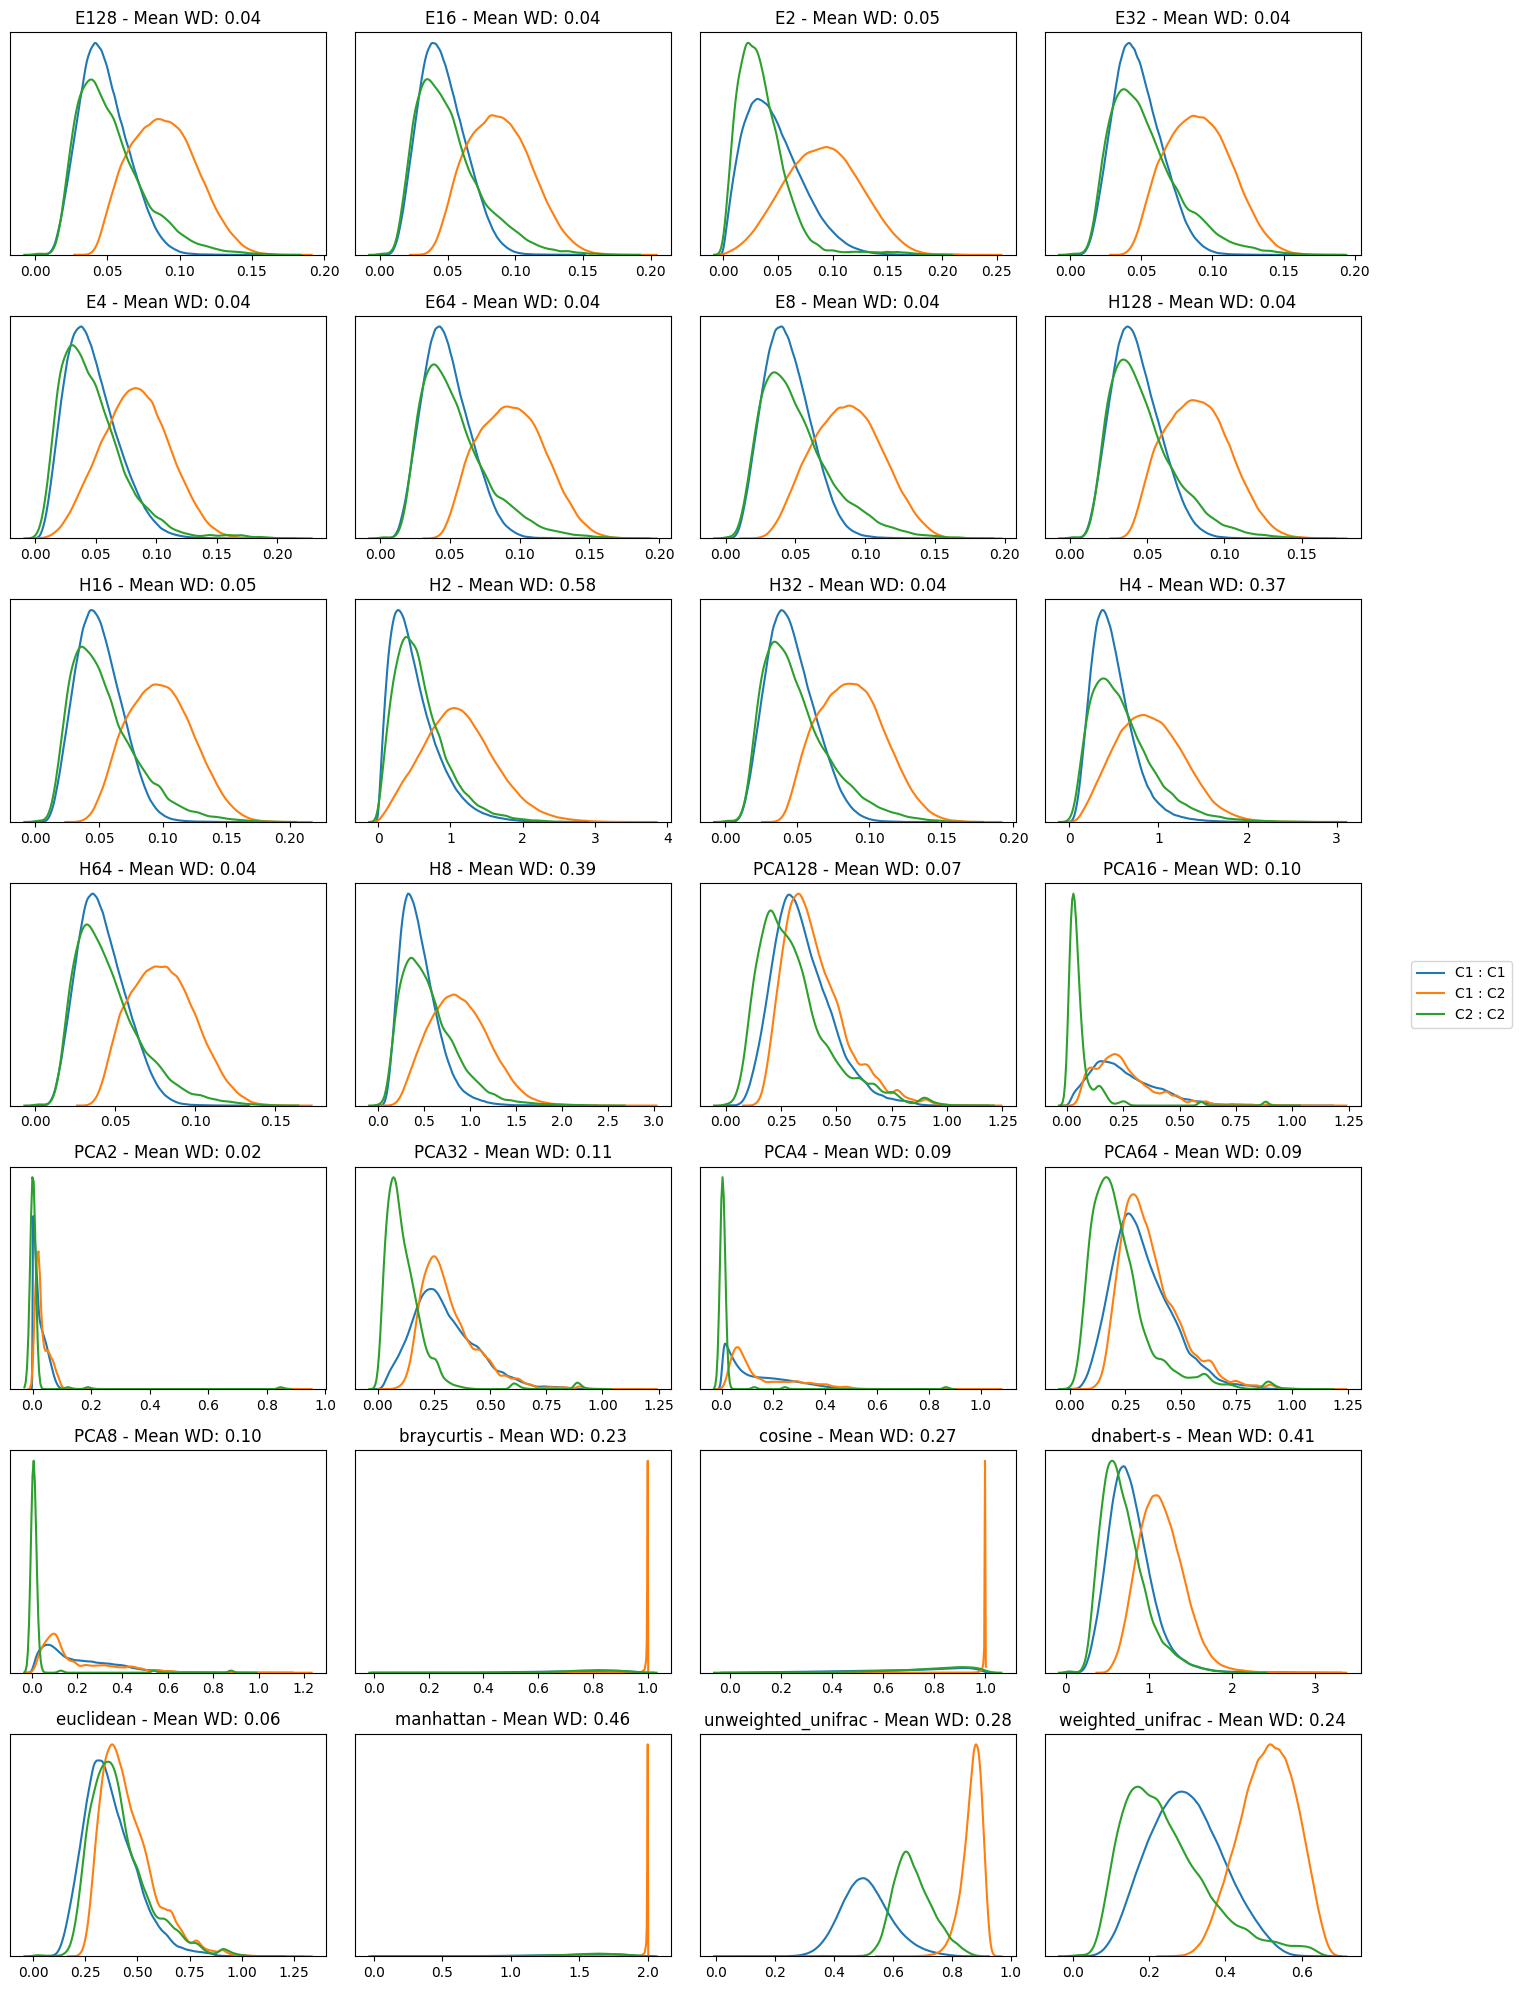

In [56]:
# There are 28 total obsp entries in MLRepo
from tqdm.notebook import tqdm

fig, axs = plt.subplots(7, 4, figsize=(15, 20)) # Page size roughly

embeddings = [
    "H2",
    "H4",
    "H8",
    "H16",
    "H32",
    "H64",
    "H128",
    "E2",
    "E4",
    "E8",
    "E16",
    "E32",
    "E64",
    "E128",
    "PCA2",
    "PCA4",
    "PCA8",
    "PCA16",
    "PCA32",
    "PCA64",
    "PCA128",
    "dnabert-s",
    "braycurtis",
    "cosine",
    "euclidean",
    "manhattan",
    "unweighted_unifrac",
    "weighted_unifrac"
]

for embedding, ax in tqdm(zip(mlrepo.obsp.keys(), axs.flatten()), total=len(mlrepo.obsp)):
    ax, wd, labels = plot_distances(embedding, DATASET, ax=ax)
    ax.set_title(f"{embedding} - Mean WD: {np.mean(wd):.2f}")
    ax.set_yticks([])
    ax.set_ylabel("")
# axs[-1, -1].legend()

# Put the legend off to the right in the middle row
axs[3, -1].legend(
    loc="center right", bbox_to_anchor=(1.5, 0.5), labels=["C1 : C1", "C1 : C2", "C2 : C2"]
)
plt.tight_layout()
plt.savefig("../figures/kdes_hmp_distances.pdf", bbox_inches="tight", dpi=300)